In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_text as text
#import tensorflow_models as tfm
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn import metrics as met
from official.nlp import optimization  # to create AdamW optimizer
import graphviz
import pydot
#import shutil
#import os
import json
import GPUtil
import time

In [3]:
class CONFIG: 
    EPS = 1e-8 
    EPOCHS = 3 # 3~5
    BATCH_SIZE = 16 # 8, 32
    LEARNING_RATE = 3e-5 # 1e-5
    MAX_LENGTH = 128 # 256
    ENCODER_TYPE = 'bert-base' # large, RoBERTa, DeBERTa
    OPTIMIZER ='adamw'   
    DEVICE_TYPE = "cuda" # Cuda or alternative
    SAVE_MODEL=False
    TASK='RE-classification'
config=CONFIG()

In [4]:
def load_dataset(path,reladict={},shuffle=False):
    with open(path,'r',encoding='UTF-8') as f:
        data=[json.loads(line) for line in f]
    sent=[]
    relation=[]
    for d in data:
        token=d['token']
        for i in range(d['h']['pos'][0],d['h']['pos'][1]):
            token[i]='[MASK]'
        for i in range(d['t']['pos'][0],d['t']['pos'][1]):
            token[i]='[MASK]'
        sent.append([' '.join(token)])
        if reladict.get(d['relation'],False)==False:
            reladict.setdefault(d['relation'],len(reladict))
        relation.append(reladict[d['relation']])
    temp=np.zeros(shape=(len(relation),len(reladict)))
    #print(temp.shape)
    #print(reladict)
    for i in range(len(relation)):
        temp[i][relation[i]]=1
    if shuffle:
        data=tf.data.Dataset.from_tensor_slices((sent,temp)).shuffle(5000).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        data=tf.data.Dataset.from_tensor_slices((sent,temp)).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return data,reladict,sent,relation
    
test_ds,reladict,testx,testy=load_dataset('semeval_test.txt')
valid_ds,reladict,validx,validy=load_dataset('semeval_val.txt',reladict,shuffle=True)
train_ds,reladict,trainx,trainy=load_dataset('semeval_train.txt',reladict,shuffle=True)

In [18]:

def evaluation(y_true,y_pred):
    acc=met.accuracy_score(y_true,y_pred)
    p=met.precision_score(y_true,y_pred,average=None,zero_division=True).tolist()
    r=met.recall_score(y_true,y_pred,average=None).tolist()
    f1=met.f1_score(y_true,y_pred,average=None).tolist()
    weighted_p=met.precision_score(y_true,y_pred,average='weighted',zero_division=True)
    weighted_r=met.recall_score(y_true,y_pred,average='weighted')
    weighted_f1=met.f1_score(y_true,y_pred,average='weighted')
    macro_p=met.precision_score(y_true,y_pred,average='macro',zero_division=True)
    macro_r=met.recall_score(y_true,y_pred,average='macro')
    macro_f1=met.f1_score(y_true,y_pred,average='macro')
    micro_p=met.precision_score(y_true,y_pred,average='micro',zero_division=True)
    micro_r=met.recall_score(y_true,y_pred,average='micro')
    micro_f1=met.f1_score(y_true,y_pred,average='micro')
    cmatrix=met.confusion_matrix(y_true,y_pred).tolist()
    return {'accuracy':acc,'confusion_matrix':cmatrix,
            'Categorical':{'precision':p,'recall':r,'f1':f1},'Weighted':{'precision':weighted_p,'recall':weighted_r,'f1':weighted_f1},
            'Macro':{'precision':macro_p,'recall':macro_r,'f1':macro_f1},'Micro':{'precision':micro_p,'recall':micro_r,'f1':micro_f1},}

In [6]:
print(reladict)
print(len(reladict))
invdict=np.zeros(len(reladict)).tolist()
for k,v in reladict.items():
    invdict[v]=k
#for text_batch, label_batch in train_ds.take(1):
  #for i in range(3):
    #print(f'Review: {text_batch.numpy()[i]}')
    #label = label_batch.numpy()[i]
    #print(f'Label : {label}')
    #print(len(label))

{'Message-Topic(e1,e2)': 0, 'Product-Producer(e2,e1)': 1, 'Instrument-Agency(e2,e1)': 2, 'Entity-Destination(e1,e2)': 3, 'Cause-Effect(e2,e1)': 4, 'Component-Whole(e1,e2)': 5, 'Product-Producer(e1,e2)': 6, 'Member-Collection(e2,e1)': 7, 'Other': 8, 'Entity-Origin(e1,e2)': 9, 'Content-Container(e1,e2)': 10, 'Entity-Origin(e2,e1)': 11, 'Cause-Effect(e1,e2)': 12, 'Component-Whole(e2,e1)': 13, 'Content-Container(e2,e1)': 14, 'Instrument-Agency(e1,e2)': 15, 'Message-Topic(e2,e1)': 16, 'Member-Collection(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18}
19


In [ ]:
tf.keras.backend.clear_session()

In [23]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = [tf.metrics.CategoricalAccuracy()]

In [8]:
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * config.EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

optimizer = optimization.create_optimizer(init_lr=CONFIG.LEARNING_RATE,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [9]:
preprocessors={'bert-base':'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
               'bert-large':'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
               'roberta-base':'https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1',
               'roberta-large':'https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1'}
layers={'bert-base':'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
        'bert-large':'https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-24-h-1024-a-16/versions/4',
        'roberta-base':'https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1',
        'roberta-large':'https://www.kaggle.com/models/kaggle/roberta/frameworks/tensorFlow2/variations/en-cased-l-24-h-1024-a-16/versions/1'}
preprocessor = hub.KerasLayer(preprocessors[config.ENCODER_TYPE], name='Preprocessor/Tokenizer')
bert_layer = hub.KerasLayer(layers[config.ENCODER_TYPE], name='Encoder',trainable=True)

In [10]:
class MaskingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskingLayer, self).__init__(**kwargs)
    def call(self, inputs):
        #return inputs[0]
        return {'input_word_ids':inputs[0]['input_word_ids'],'input_type_ids':tf.math.add(inputs[0]['input_type_ids'],inputs[1]),'input_mask':tf.math.add(inputs[0]['input_mask'],tf.math.multiply(inputs[1],-1))}

def build_classifier_model(output_shape):
    #position_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='mask')
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = preprocessor
    #masklayer = MaskingLayer()
    encoder_inputs = preprocessing_layer(text_input)
    #encoder_inputs = masklayer([encoder_inputs,position_input])
    encoder = bert_layer
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    #net = tf.keras.layers.Dropout(0.1)(net)
    #net = tf.keras.layers.Dense(128, activation=None, name='shuffler')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(output_shape, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [11]:
#text_test=['this is such an amazing movie!']
model = build_classifier_model(len(reladict))
tf.keras.utils.plot_model(model,'results/img/model.png')
#print(model.summary())
#bert_raw_result = model([tf.constant(text_test)])
#print(tf.sigmoid(bert_raw_result))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 Preprocessor/Tokenizer (KerasL  {'input_word_ids':   0          ['text[0][0]']                   
 ayer)                          (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [12]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
trs_time=time.process_time()
history=model.fit(train_ds,validation_data=valid_ds,verbose=1,epochs=CONFIG.EPOCHS)
tre_time=time.process_time()
train_time=tre_time-trs_time

Epoch 1/3
407/407 [==============================] - 139s 314ms/step - loss: 1.9523 - categorical_accuracy: 0.4060 - val_loss: 0.9861 - val_categorical_accuracy: 0.7040
Epoch 2/3
407/407 [==============================] - 103s 254ms/step - loss: 0.8187 - categorical_accuracy: 0.7443 - val_loss: 0.8009 - val_categorical_accuracy: 0.7448
Epoch 3/3
407/407 [==============================] - 103s 254ms/step - loss: 0.5371 - categorical_accuracy: 0.8317 - val_loss: 0.7808 - val_categorical_accuracy: 0.7508


In [13]:
#print(history.history)
model_name="{}_EP{}_BS{}_LR{}_ML{}".format(config.ENCODER_TYPE,config.EPOCHS,config.BATCH_SIZE,config.LEARNING_RATE,config.MAX_LENGTH)
model_name

'bert-base_EP3_BS16_LR3e-05_ML128'

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


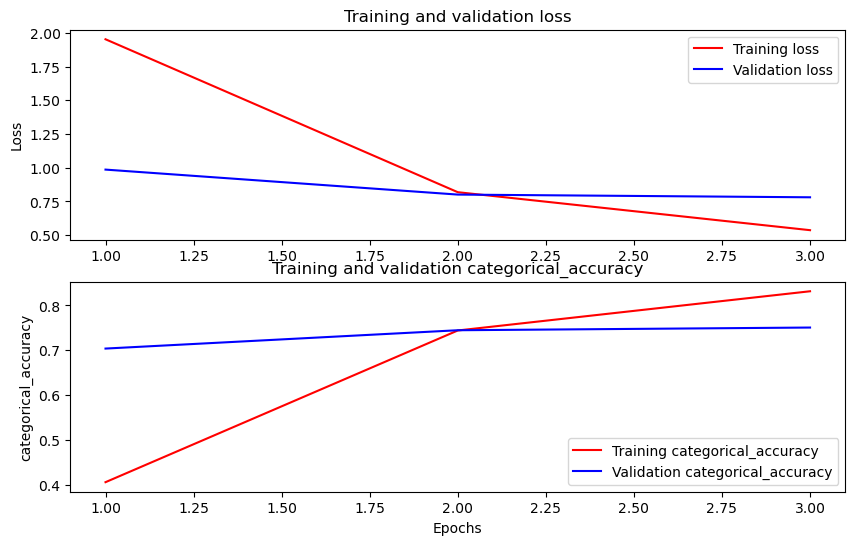

In [16]:
history_dict = history.history
print(history_dict.keys())

metrics_name=[m.name for m in metrics]

fig = plt.figure(figsize=(10, 3*(len(metrics_name)+1)))
fig.tight_layout()
epochs = range(1, config.EPOCHS + 1)

plt.subplot(len(metrics_name)+1, 1, 1)
# r is for "solid red line"
plt.plot(epochs, history_dict['loss'], 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

for i in range(0,len(metrics_name)):

    plt.subplot(len(metrics_name)+1, 1, i+2)
    plt.plot(epochs, history_dict[metrics_name[i]], 'r', label='Training {}'.format(metrics_name[i]))
    plt.plot(epochs, history_dict['val_{}'.format(metrics_name[i])], 'b', label='Validation {}'.format(metrics_name[i]))
    plt.title('Training and validation {}'.format(metrics_name[i]))
    plt.ylabel(metrics_name[i])
    plt.legend(loc='lower right')
    
plt.xlabel('Epochs')
plt.savefig('results/img/RE/{}_history.png'.format(model_name))
plt.close()

170/170 [==============================] - 11s 65ms/step


<AxesSubplot:>

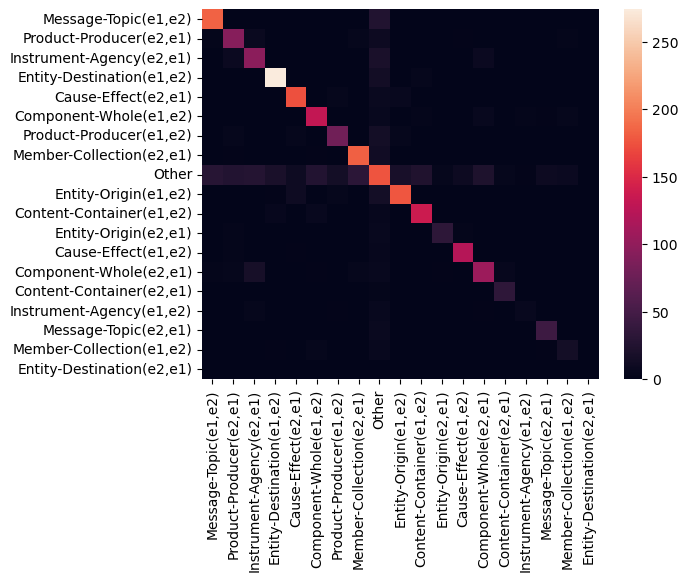

In [36]:
tss_time= time.process_time()
y_pred=model.predict(testx,batch_size=CONFIG.BATCH_SIZE).argmax(axis=1)
tse_time= time.process_time()
test_time=tse_time-tss_time
y_true=testy
test_result=evaluation(y_true,y_pred)
test_result.setdefault('History',history.history)
test_result.setdefault('Time_cost',{'train':train_time,'test':test_time})
test_result.setdefault('Original',{'y_true':y_true,'y_pred':[int(x) for x in y_pred]})
#matrix=tf.math.confusion_matrix(y_true,y_pred).numpy()
sbn.heatmap(test_result['confusion_matrix'],xticklabels=invdict,yticklabels=invdict,annot=False)

In [37]:
metadata={'model_type':config.ENCODER_TYPE,
          'task_type':config.TASK,
          'epochs':config.EPOCHS,
          'learning_rate':config.LEARNING_RATE,
          'batch_size':config.BATCH_SIZE,
          'max_length':config.MAX_LENGTH,
          'model_name':model_name,
          'optimizer':optimizer._name,
          'metrics':[m.name for m in metrics],
          'loss':loss.name,
          'class_name':invdict,
          'is_saved':config.SAVE_MODEL,
          'devices':[gpu.name for gpu in GPUtil.getAvailable()],
          'structure':model.summary()
          }

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 Preprocessor/Tokenizer (KerasL  {'input_word_ids':   0          ['text[0][0]']                   
 ayer)                          (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
metadata={'model_type':config.ENCODER_TYPE,
          'task_type':config.TASK,
          'epochs':config.EPOCHS,
          'learning_rate':config.LEARNING_RATE,
          'batch_size':config.BATCH_SIZE,
          'max_length':config.MAX_LENGTH,
          'model_name':model_name,
          'optimizer':optimizer._name,
          'metrics':[m.name for m in metrics],
          'loss':loss.name,
          'class_name':invdict,
          'is_saved':config.SAVE_MODEL,
          'devices':[gpu.name for gpu in GPUtil.getAvailable()],
          'structure':model.summary()
          }

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 Preprocessor/Tokenizer (KerasL  {'input_word_ids':   0          ['text[0][0]']                   
 ayer)                          (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [42]:
if config.SAVE_MODEL:
    model.save('models/{}'.format(model_name))
saved_data={'Metadata':metadata,
            'Result':test_result}
with open('results/NRE_test_result.json','r',encoding='UTF-8')as f:
    s=json.load(f)
s.setdefault('task',config.TASK)
s.setdefault('Results',[])
s['Results'].append(saved_data)
with open('results/NRE_test_result.json','w',encoding='UTF-8')as f:
    json.dump(s,f,indent=2)